# Making imports

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D, BatchNormalization, LayerNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from collections import Counter

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Alex-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Alex-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Alex-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Visualizing and exploring the data

In [5]:
training_data = pd.read_csv("data/train.csv")
validation_data = pd.read_csv("data/val.csv")
testing_data = pd.read_csv("data/test.csv")

In [69]:
def plot_scores_histogram(scores):
    plt.figure(figsize=(8, 6))
    plt.hist(scores, bins=int((scores.max() - scores.min()) / 0.25), edgecolor='black', color='skyblue')
    plt.title("Histogram of Train Data Scores", fontsize=16)
    plt.xlabel("Score", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Training data length is 8000 with scores having: mean 0.5207909438130168 and standard deviation 0.8171235305321966
       id                                               text     score
0  196112  A sandwich and french bread sit on a cutting b... -0.666667
1  514558  A baseball player is standing on the field whi...  0.000000
2   54244  A casserole served at a restaurant in a brown ...  1.333333
3    9420    OLD BLACK AND WHITE PHOTO OF AN ALL BOYS SCHOOL  1.666667
4  531512    A woman is milking a cow in the animal stable.   0.250000


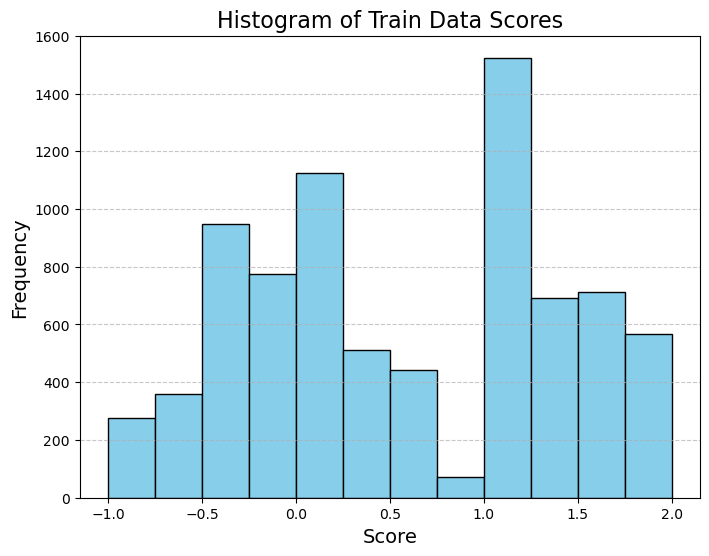

In [71]:
print(f"Training data length is {len(training_data)} with scores having: mean {training_data["score"].mean()} and standard deviation {training_data["score"].std()}")
print(training_data.head()) 
plot_scores_histogram(training_data["score"])

Validation data length is 500 with scores having: mean 0.4804607335511433 and standard deviation 0.8154152344312598
       id                                               text     score
0  227928     A surfer on his surfboard performing a move.   -0.250000
1  438306    a passenger train going down a track by a fence  1.566667
2   34827  A open refrigerator door reveals that it is we...  1.250000
3  486397           A woman leads two sheep down the street. -0.833333
4  328203  A baseball player running towards base while t...  0.000000


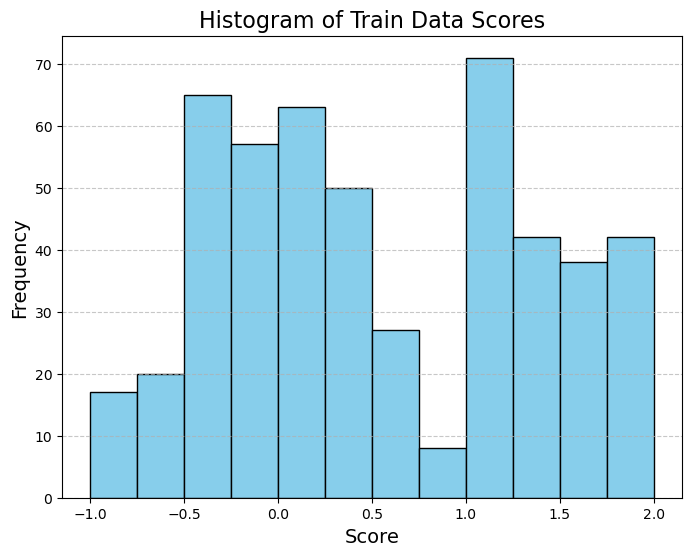

In [73]:
print(f"Validation data length is {len(validation_data)} with scores having: mean {validation_data["score"].mean()} and standard deviation {validation_data["score"].std()}")
print(validation_data.head()) 
plot_scores_histogram(validation_data["score"])

In [74]:
print(len(testing_data))
print(testing_data.head())

500
       id                                               text
0  456197  A large building with a clock tower surrounded...
1  138368  A woman hitting a tennis ball with a tennis ra...
2   63856  Skaters are skateboarding at the park while a ...
3  308947  Several firetrucks and firefighters are parked...
4   57992  Two black horses running on a hill with trees ...


# Split data and preprocess it

In [44]:
neural_network_score, random_forest_score, ridge_score, lasso_score, support_vector_score, combined_model_score = [0, 0, 0, 0, 0, 0]

In [18]:
training_texts, training_scores = training_data["text"], training_data["score"]
validation_texts, validation_scores = validation_data["text"], validation_data["score"]

In [19]:
testing_texts = testing_data["text"]
testing_ids = testing_data["id"]

In [20]:
lemmatizer = WordNetLemmatizer()
english_stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in english_stop_words]
    return ' '.join(tokens)

In [21]:
training_texts_processed = [preprocess_text(text) for text in training_texts]
validation_texts_processed = [preprocess_text(text) for text in validation_texts]
testing_texts_processed = [preprocess_text(text) for text in testing_texts]

In [80]:
print(training_texts[0])
print(training_texts_processed[0])

A sandwich and french bread sit on a cutting board with an apple.
sandwich french bread sit cutting board apple


In [77]:
all_training_tokens = ' '.join(training_texts_processed).split()
all_validation_tokens = ' '.join(validation_texts_processed).split()
all_testing_tokens = ' '.join(testing_texts_processed).split()

training_vocab_size = len(set(all_training_tokens))
validation_vocab_size = len(set(all_validation_tokens))
testing_vocab_size = len(set(all_testing_tokens))

print(f"Training Vocabulary Size: {training_vocab_size}")
print(f"Validation Vocabulary Size: {validation_vocab_size}")
print(f"Testing Vocabulary Size: {testing_vocab_size}")

training_word_counts = Counter(all_training_tokens)
validation_word_counts = Counter(all_validation_tokens)
testing_word_counts = Counter(all_testing_tokens)

most_common_training_words = training_word_counts.most_common(10)
most_common_validation_words = validation_word_counts.most_common(10)
most_common_testing_words = testing_word_counts.most_common(10)

print("\nMost Common Words in Training Set:")
print(most_common_training_words)

print("\nMost Common Words in Validation Set:")
print(most_common_validation_words)

print("\nMost Common Words in Testing Set:")
print(most_common_testing_words)

Training Vocabulary Size: 4107
Validation Vocabulary Size: 956
Testing Vocabulary Size: 1291

Most Common Words in Training Set:
[('man', 819), ('white', 708), ('two', 671), ('sitting', 536), ('standing', 511), ('people', 501), ('woman', 483), ('street', 445), ('large', 439), ('next', 415)]

Most Common Words in Validation Set:
[('man', 54), ('two', 37), ('standing', 34), ('sitting', 33), ('white', 32), ('woman', 31), ('people', 28), ('street', 27), ('front', 25), ('large', 24)]

Most Common Words in Testing Set:
[('two', 40), ('sitting', 40), ('red', 37), ('man', 33), ('large', 30), ('dog', 29), ('street', 25), ('cat', 25), ('blue', 25), ('white', 24)]


# Vectorizing the text data

In [25]:
nonNN_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))  
nonNN_training_features = nonNN_vectorizer.fit_transform(training_texts_processed).toarray()
nonNN_validation_features = nonNN_vectorizer.transform(validation_texts_processed).toarray()
nonNN_testing_features = nonNN_vectorizer.transform(testing_texts_processed).toarray()

print(training_texts[0])
print(training_texts_processed[0])
print(nonNN_testing_features[0])

A sandwich and french bread sit on a cutting board with an apple.
sandwich french bread sit cutting board apple
[0. 0. 0. ... 0. 0. 0.]


In [86]:
max_tokens = 5000 
sequence_length = 100 

NN_vectorizer = TextVectorization(
    max_tokens=max_tokens, 
    output_sequence_length=sequence_length
) 
NN_vectorizer.adapt(training_texts)

print(training_texts[0])
print(training_texts_processed[0])
print(NN_vectorizer(training_texts[0]))

A sandwich and french bread sit on a cutting board with an apple.
sandwich french bread sit cutting board apple
tf.Tensor(
[  1 140   1 585 433 216   1   1 208  97   1   1 225   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int64)


# Neural Network Model

In [91]:
embedding_dimmension = 128
tf.random.set_seed(42)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

model = Sequential([
    NN_vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dimmension, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, recurrent_regularizer=l2(0.01), kernel_regularizer=l2(0.01))),
    GlobalAveragePooling1D(),
    Dense(64, activation="relu", kernel_regularizer=l2(0.03)),
    Dropout(0.5),
    Dense(1)  
])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mae"]
)

history = model.fit(
    training_texts,
    training_scores,
    validation_data=(validation_texts, validation_scores),
    epochs=18,
    batch_size=32
)

Epoch 1/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - loss: 4.0443 - mae: 0.7169 - val_loss: 0.5399 - val_mae: 0.5834
Epoch 2/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - loss: 0.5310 - mae: 0.5716 - val_loss: 0.4913 - val_mae: 0.5480
Epoch 3/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 0.4663 - mae: 0.5256 - val_loss: 0.4749 - val_mae: 0.5323
Epoch 4/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.4411 - mae: 0.5031 - val_loss: 0.4656 - val_mae: 0.5258
Epoch 5/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.4147 - mae: 0.4844 - val_loss: 0.4548 - val_mae: 0.5165
Epoch 6/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - loss: 0.3932 - mae: 0.4636 - val_loss: 0.4579 - val_mae: 0.5097
Epoch 7/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - loss: 0.3802 - mae: 0.4584 - val_loss: 0.4600 - val_mae: 0.5096
Epoch 8/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.3629 - mae: 0.4454 - val_loss: 0.4649 - val_mae: 0.5103
Epoch 9/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 

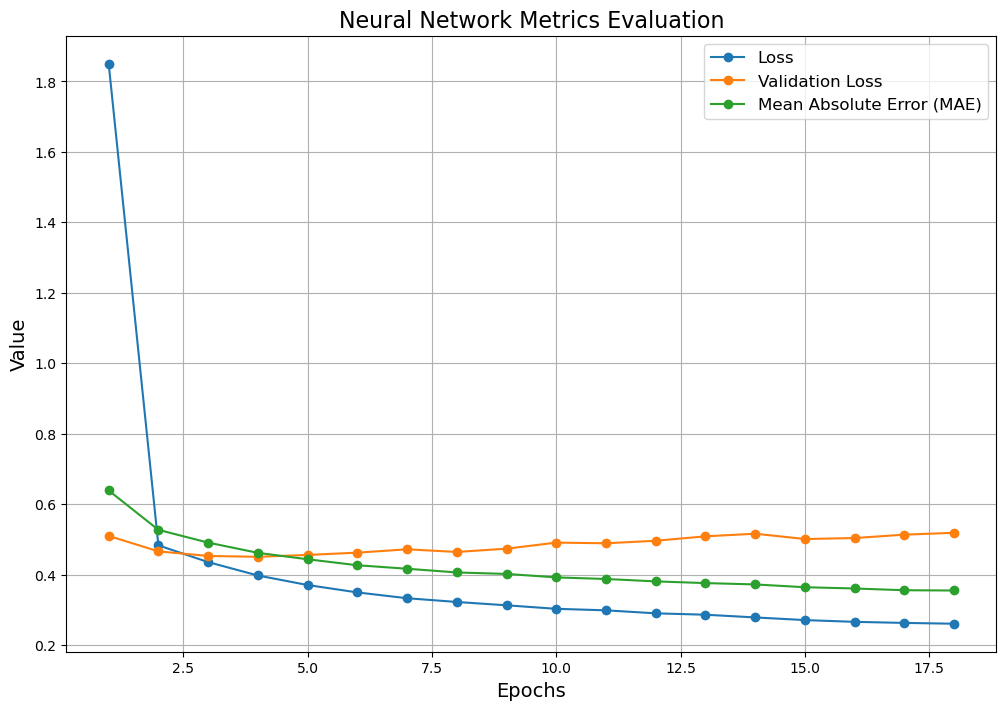

In [45]:
epochs = range(1, len(history.history["loss"]) + 1)
loss_evolution = history.history["loss"]
val_loss_evolution = history.history["val_loss"]
mae_evolution = history.history["mae"]

plt.figure(figsize=(12, 8))

plt.plot(epochs, loss_evolution, label="Loss", marker="o")
plt.plot(epochs, val_loss_evolution, label="Validation Loss", marker="o")

plt.plot(epochs, mae_evolution, label="Mean Absolute Error (MAE)", marker="o")

plt.title("Neural Network Metrics Evaluation", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [92]:
nn_predictions = model.predict(validation_texts).flatten()
neural_network_score = spearmanr(validation_scores, nn_predictions).correlation
print(f"Neural Network Spearman Score: {neural_network_score}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Neural Network Spearman Score: 0.5331729578500569


In [85]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (32, 100)              │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (32, 100, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (32, 100, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (32, 256)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,519,044 (32.50 MB)

 Trainable params: 2,839,681 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,679,363 (21.67 MB)

# Non Neural Network options

## Random Forest

In [ ]:
random_forest_parameters = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300]
}
random_forest_grid_search = GridSearchCV(RandomForestRegressor(), random_forest_parameters, cv=5, scoring='neg_mean_squared_error')
random_forest_grid_search.fit(nonNN_training_features, training_scores)
random_forest_grid_search.best_params_

In [46]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(nonNN_training_features, training_scores)

RandomForestRegressor(random_state=42)

## Ridge Regression

In [48]:
ridge_parameters = {
    'alpha': [0.001, 0.1, 1.0, 10, 20, 30, 40, 50, 60, 70, 100]
}
ridge_grid_search = GridSearchCV(Ridge(), ridge_parameters, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(nonNN_training_features, training_scores)
ridge_grid_search.best_params_

{'alpha': 10, 'solver': 'lsqr'}

In [49]:
ridge_model = Ridge(alpha=6.0, solver='lsqr')  
ridge_model.fit(nonNN_training_features, training_scores)

Ridge(alpha=6.0, solver='lsqr')

## Lasso Regression Model

In [ ]:
lasso_parameters = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 20, 30, 40, 50, 60, 70, 100]
}
lasso_grid_search = GridSearchCV(Lasso(max_iter=10000), lasso_parameters, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(nonNN_training_features, training_scores)
lasso_grid_search.best_params_

In [50]:
lasso_model = Lasso(alpha=0.0005, max_iter=10000, random_state=42) 
lasso_model.fit(nonNN_training_features, training_scores)

Lasso(alpha=0.0005, max_iter=10000, random_state=42)

## Support Vector Regression (SVR)

In [51]:
svr_param_grid = {
    "C": [0.01, 0.1, 1],
    "epsilon": [0.01, 0.1, 1],
}
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, scoring="neg_mean_squared_error", cv=3)
svr_grid_search.fit(nonNN_training_features, training_scores)
svr_grid_search.best_params_

{'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}

In [52]:
svr_model = SVR(kernel="linear", C=0.1, epsilon=0.1)
svr_model.fit(nonNN_training_features, training_scores)

SVR(C=0.1, kernel='linear')

# Making predictions and evaluations

# Random Forest Predictions

RANDOM FOREST - Validation data length is 500 with scores having: mean 0.5308915745898941 and standard deviation 0.5614356196914896


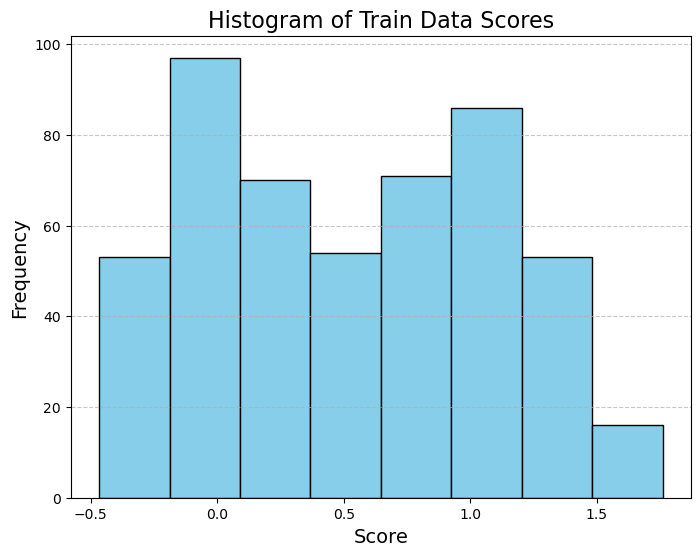

In [54]:
random_forest_score_predictions = random_forest_model.predict(nonNN_validation_features)
print(f"RANDOM FOREST - Validation data length is {random_forest_score_predictions.size} with scores having: mean {random_forest_score_predictions.mean()} and standard deviation {random_forest_score_predictions.std()}")
plot_scores_histogram(random_forest_score_predictions)

## Ridge Predictions

RIDGE - Validation data length is 500 with scores having: mean 0.5045232442278993 and standard deviation 0.440689173585581


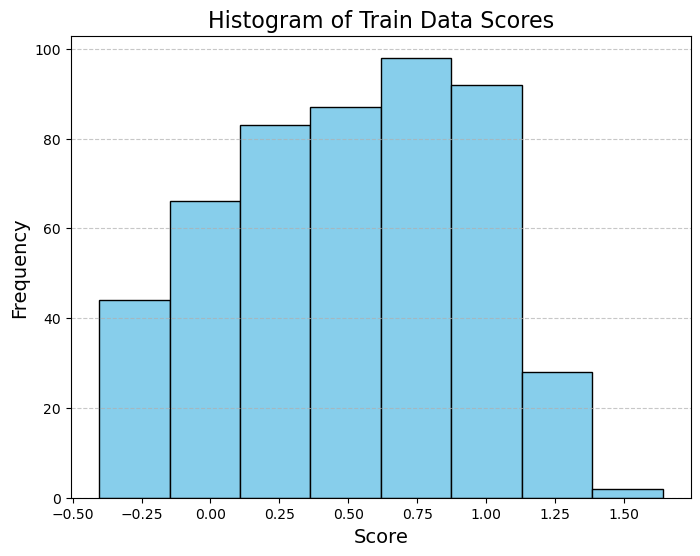

In [53]:
ridge_score_predictions = ridge_model.predict(nonNN_validation_features)
print(f"RIDGE - Validation data length is {ridge_score_predictions.size} with scores having: mean {ridge_score_predictions.mean()} and standard deviation {ridge_score_predictions.std()}")
plot_scores_histogram(ridge_score_predictions)

## Lasso Predictions

LASSO - Validation data length is 500 with scores having: mean 0.5129820713990475 and standard deviation 0.41506722530902573


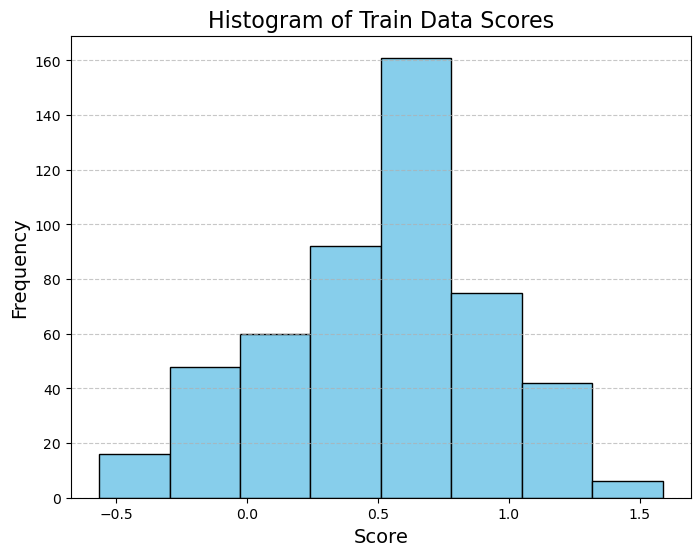

In [55]:
lasso_score_predictions = lasso_model.predict(nonNN_validation_features)
print(f"LASSO - Validation data length is {lasso_score_predictions.size} with scores having: mean {lasso_score_predictions.mean()} and standard deviation {lasso_score_predictions.std()}")
plot_scores_histogram(lasso_score_predictions)

## SVR Predictions

SVR - Validation data length is 500 with scores having: mean 0.5420542375428719 and standard deviation 0.5003294441501066


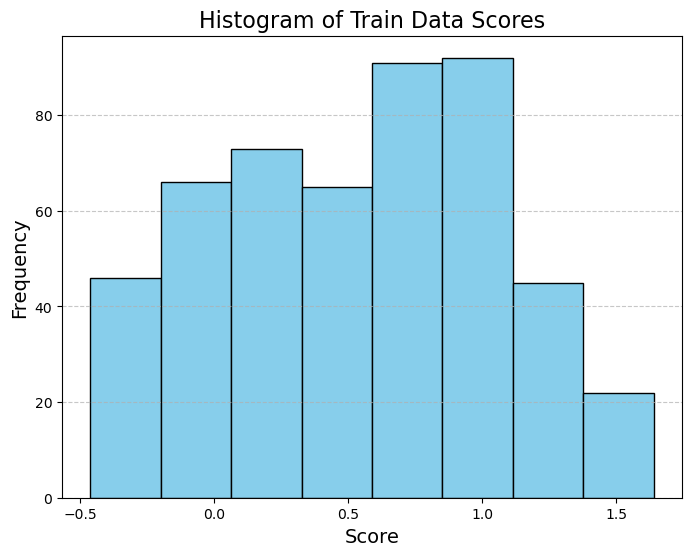

In [56]:
svr_score_predictions = svr_model.predict(nonNN_validation_features)
print(f"SVR - Validation data length is {svr_score_predictions.size} with scores having: mean {svr_score_predictions.mean()} and standard deviation {svr_score_predictions.std()}")
plot_scores_histogram(svr_score_predictions)

## Getting spearman scores on all models

In [58]:
random_forest_score = spearmanr(validation_scores, random_forest_score_predictions).correlation
ridge_score = spearmanr(validation_scores, ridge_score_predictions).correlation
lasso_score = spearmanr(validation_scores, lasso_score_predictions).correlation
support_vector_score = spearmanr(validation_scores, svr_score_predictions).correlation

print(f"Random Forest: {random_forest_score}, Ridge: {ridge_score}, Lasso: {lasso_score}, Support Vector: {support_vector_score}")

Random Forest: 0.5858997956891087, Ridge: 0.6067673865466267, Lasso: 0.5707103375985584, Support Vector: 0.59971866035178


## Combined models using weighted average

In [61]:
total_score = random_forest_score + ridge_score + lasso_score + support_vector_score
random_forest_weight = random_forest_score / total_score
ridge_weight = ridge_score / total_score
lasso_weight = lasso_score / total_score
support_vector_weight = support_vector_score / total_score

print(f"Random Forest Weight: {random_forest_weight}, Ridge Weight: {ridge_weight}, Lasso Weight: {lasso_weight}, Support Vector Weight: {support_vector_weight}")

# Weighted average of predictions
final_predictions = (random_forest_weight * random_forest_score_predictions + 
                     ridge_weight * ridge_score_predictions +
                     lasso_weight * lasso_score_predictions +
                     support_vector_weight * svr_score_predictions)

final_score = spearmanr(validation_scores, final_predictions).correlation
print(f"Combined Model Spearman Score: {final_score}")

Random Forest Weight: 0.24793734618240296, Ridge Weight: 0.25676796045552785, Lasso Weight: 0.24150956799126974, Support Vector Weight: 0.25378512537079945
Combined Model Spearman Score: 0.6093642375972341


# Preparing the submission using best and combined model

## Getting predictions on test data with best model

BEST - Validation data length is 500 with scores having: mean 0.5527157862414328 and standard deviation 0.3756915210632841


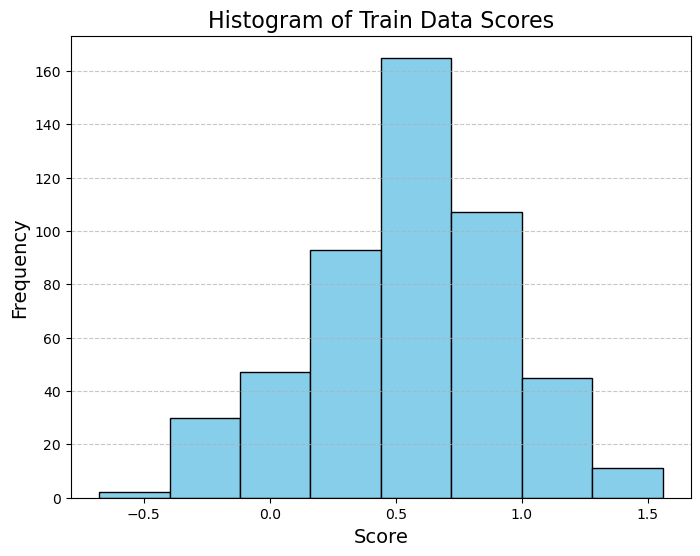

In [63]:
testing_score_predictions = ridge_model.predict(nonNN_testing_features)
print(f"BEST - Validation data length is {testing_score_predictions.size} with scores having: mean {testing_score_predictions.mean()} and standard deviation {testing_score_predictions.std()}")
plot_scores_histogram(testing_score_predictions)

In [68]:
output_df = pd.DataFrame({
    "id": np.array(testing_ids).flatten(),
    "score": testing_score_predictions.flatten()
})

output_df.to_csv("saves/submission_ridge_clear.csv", index=False)

## Getting predictions on test data using combined model

In [65]:
random_forest_score_test_predictions = random_forest_model.predict(nonNN_testing_features)
ridge_score_test_predictions = ridge_model.predict(nonNN_testing_features)
lasso_score_test_predictions = lasso_model.predict(nonNN_testing_features)
svr_score_test_predictions = svr_model.predict(nonNN_testing_features)

final_test_predictions = (random_forest_weight * random_forest_score_test_predictions + 
                     ridge_weight * ridge_score_test_predictions +
                     lasso_weight * lasso_score_test_predictions +
                     support_vector_weight * svr_score_test_predictions)

BEST - Validation data length is 500 with scores having: mean 0.5808999091735931 and standard deviation 0.3903921144064291


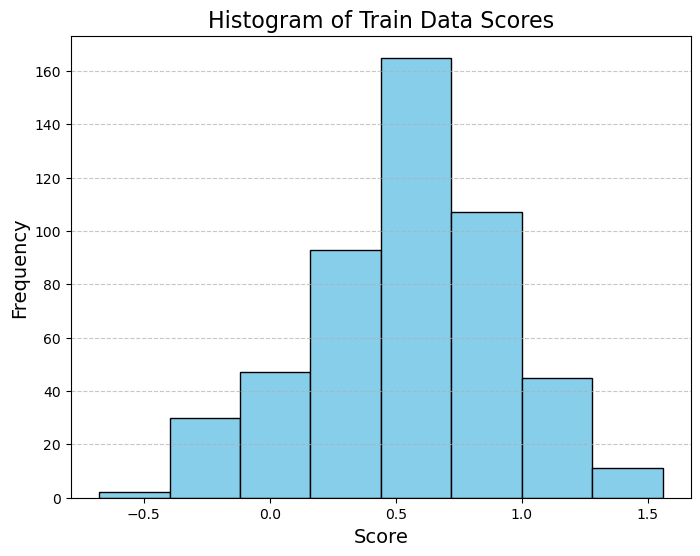

In [66]:
print(f"BEST - Validation data length is {final_test_predictions.size} with scores having: mean {final_test_predictions.mean()} and standard deviation {final_test_predictions.std()}")
plot_scores_histogram(testing_score_predictions)

In [67]:
output_df = pd.DataFrame({
    "id": np.array(testing_ids).flatten(),
    "score": final_test_predictions.flatten()
})

output_df.to_csv("saves/submission_combined_clear.csv", index=False)